# <font style="color:blue">Indian Meal Classification</font>


## <font style="color:green">Section 1: Data Loader</font>

In [1]:
%matplotlib inline

In [24]:
import glob
import os.path
import time
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import numpy as np
import random
from pprint import pp
from typing import List
import threading
import subprocess as cmd
import math

import torch
import torch.nn.functional as Func
from torch.utils.data import Dataset
from torchvision import transforms, datasets
from torchvision.transforms import functional as F
from dataclasses import dataclass

from PIL import Image

In [3]:
class DatasetCreation():
    """
    Create the folders for the Indian Meal dataset if they do not exist.
    """ 
    def __init__(self, data_root, valid_perc=0.2):
        if valid_perc < 0 or valid_perc > 100:
            raise ValueError("The validation percentage is < 0 or > 100!")

        self._train_num = 0  # The number of stored training images
        self._valid_num = 0  # The number of stored validation images
        self._test_num = 0  # The number of stored testing images
        self._root_dir = data_root
        self.train_path = os.path.join(data_root, 'training', 'training')
        self.valid_path = os.path.join(data_root, 'validation', 'validation')
        self.test_path = os.path.join(data_root, 'testing', 'testing')

        # Calculate the number of training and validation images based on the percentage
        image_path = os.path.join(self._root_dir, 'images', 'images')

        if not os.path.exists(self.train_path):
            print('Creating Training set...')
            # Create the training data frame
            label_csv_train = os.path.join(self._root_dir, 'train.csv')
            df_train = pd.read_csv(label_csv_train, delimiter=',', header=0)

            os.makedirs(self.train_path)
            for idx, (img_name, class_folder) in enumerate(zip(df_train['id'], df_train['class'])):
                class_folder_path = os.path.join(self.train_path, class_folder)
                dest_class_folder_image = os.path.join(class_folder_path, str(img_name) + '.jpg')
                ### CODE REMOVED

        if not os.path.exists(self.valid_path):
            print('Creating Validation set...')

            os.makedirs(self.valid_path)
            for root, dirs, _ in os.walk(self.train_path):
                for class_dir in dirs:
                    class_path = os.path.join(self.train_path, class_dir)
                    # Calculate the number of the test set based on the percentage
                    valid_image_num = int(len(os.listdir(class_path)) * valid_perc)
                    ### CODE REMOVED

        if not os.path.exists(self.test_path):
            print('Creating Testing set...')
            # Create the testing data frame
            label_csv_test = os.path.join(self._root_dir, 'test.csv')
            df_test = pd.read_csv(label_csv_test, delimiter=',', header=0)

            os.makedirs(self.test_path)
            for img_name in df_test['id']:
                # Check if the class folder exists, else create it.
                dest_test_folder_image = os.path.join(self.test_path, str(img_name) + '.jpg')
                ### CODE REMOVED

        if os.path.exists(image_path):
            #shutil.rmtree(image_path)
            print('Creation completed!')
        else:
            dataset_name = self._root_dir.split('/')[-1]
            print(f'Dataset {dataset_name.upper()} still exists!')

        # Calculate number of training, validation and testing images
        for root, dirs, files in os.walk(self.train_path):
            self._train_num += len(files)
        for root, dirs, files in os.walk(self.valid_path):
            self._valid_num += len(files)
        for root, dirs, files in os.walk(self.test_path):
            self._test_num += len(files)

In [4]:
class IndianMealDataset(Dataset):
    """
    The Dataset class to load the training, validation and testing data.
    """
    @property
    def num_classes(self): return self._num_classes
    @property
    def root_dir(self): return self._data_root
    @property
    def data_dir(self): return self._data_dir
    @property
    def num_images(self): return self._num_images
    @property
    def data_dict(self): return self._data_dict

    def __init__(self, data_root, train=True, image_shape=None, transform=None):
        self.transform = transform
        self._data_root = data_root
        self._num_classes = 0
        self._num_images = 0
        self._data_dict = {
            'image_path': [],
            'label': []
        }

        # Set the image_resize attribute
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            elif isinstance(image_shape, tuple) or isinstance(image_shape, list):
                assert len(image_shape) == 1 or len(image_shape) == 2, '[Warning] Invalid image_shape tuple size'
                if len(image_shape) == 1:
                    self.image_shape = (image_shape[0], image_shape[0])
                else:
                    self.image_shape = image_shape
            else:
                raise NotImplementedError
        else:
            self.image_shape = image_shape

        if train:
            self._data_dir = os.path.join(data_root, 'training', 'training')
        elif train is False:
            self._data_dir = os.path.join(data_root, 'validation', 'validation')
        elif train is None:
            self._data_dir = os.path.join(data_root, 'testing', 'testing')

        # Calculate number of training, validation and testing images
        for root, dirs, files in os.walk(self._data_dir):
            self._num_images += len(files)
        self._create(self._data_dir, train)

    def __len__(self):
        return len(self._data_dict['label']) # return length of the dataset

    def __getitem__(self, idx):
        # For given index, return images with resize and preprocessing.
        image = Image.open(self._data_dict['image_path'][idx]).convert("RGB")
        if self.image_shape is not None:
            image = F.resize(image, self.image_shape) #F.resize(img_transform(image), self.image_shape)
        if self.transform is not None:
            image = self.transform(image)
        target = self._data_dict['label'][idx]
        return image, target, self._data_dict['image_path'][idx]

    def _create(self, img_dir, train):
        """
        :img_dir: The directory to read the images from
        :train: The dataset type to create, if None the test set gets created
        """
        if train is None:
            # Create the test-set only
            for image_path in glob.iglob(f'{img_dir}/*'):
                if image_path.endswith(".jpg") or image_path.endswith(".png"):
                    ### CODE REMOVED
        else:
            for root, dirs, _ in os.walk(img_dir):
                for i, class_dir in enumerate(dirs):
                    class_path = os.path.join(img_dir, class_dir)
                    ### CODE REMOVED
            
            # Calculate the number of classes
            train_path = os.path.join(self._data_root, 'training', 'training')
            for _, dirs, _ in os.walk(train_path):
                if train is not None:
                    self._num_classes = len(dirs)
                break


In [5]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    return torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)

In [6]:
def get_mean_std(data_root, num_workers=4):
    """
    Calculates the mean and the standard deviation.
    """
    transform = image_preprocess_transforms()
    loader = data_loader(data_root, transform)
    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)
    
    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3))
        batch_mean_sqrd += (batch_data ** 2).mean(dim=(0, 2, 3))
    
    mean = batch_mean / len(loader)
    var = (batch_mean_sqrd / len(loader)) - (mean ** 2)     
    std = var ** 0.5
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

In [7]:
def image_preprocess_transforms():
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])
    return preprocess

def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    return common_transforms

In [8]:
def get_data(batch_size, data_root, num_workers=4, data_augmentation=False):
    torch.cuda.empty_cache() # This will release any unused memory

    # Applies data augmentation if desired
    def data_augmentation_preprocess(mean, std, transformations):
        return transforms.Compose([
            transformations,
            transforms.RandomChoice([
                ### CODE REMOVED
            ]),
            transforms.Normalize(mean=mean, std=std)
        ])
        
    train_data_path = os.path.join(data_root, 'training', 'training')
    mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
    common_transforms = image_preprocess_transforms()

    ### CODE REMOVED
    
    # Create the training, validation and test loader
    # Note: Use data augmentation for both training and validation process to prevent overfitting.
    ### CODE REMOVED
    
    torch.cuda.empty_cache()  # This will release any unused memory

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=train_config.batch_size,
                                              shuffle=False,
                                              num_workers=train_config.num_workers)


    return train_loader, valid_loader, test_loader

## <font style="color:green">Section 2: Configuration</font>

**Define your configuration here.**

In [9]:
from dataclasses import dataclass

In [25]:
@dataclass
class TrainingConfiguration:
    '''
    Describes the configuration of the training process.
    '''
    batch_size: int = ... ### CODE REMOVED
    epochs_count: int = 50
    init_learning_rate: float = ... ### CODE REMOVED
    log_interval: int = 100
    valid_interval: int = 1
    data_root: str = "./dataset"
    num_workers: int = 4
    device: str = 'cuda'

In [11]:
@dataclass
class SystemConf:
    '''
    Describes the common system setting for reproducible training
    '''
    seed: int = 42 # Seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True # Enable CuDNN benchmark to improve the performance
    cudnn_deterministic: bool = True  # Cudnn deterministic (reproducible training)
    gpu_support = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
@dataclass
class DatasetConfig:
    num_classes: int = 13 # The number of output classes
    img_height:  int = 224 # The height of the images stored
    img_width:   int = 224 # The width of the images stored
    channels:    int = 3 # The number of channels of the images
    data_aug:    bool = True # Determines if Dataugmentation should be used
    num_workers: int = 4 # Number of concurrent processes to prepare data
    data_root: str = "./dataset"

## <font style="color:green">Section 3: Evaluation Metric</font>

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from sklearn.metrics import roc_curve, roc_auc_score

In [14]:
class EvaluationMetrics:

    def accuracy(self, targets, predictions):
        acc = accuracy_score(y_true=targets, y_pred=predictions, normalize=True)
        print('The accuracy is {}%'.format(acc * 100.))
        return

    def f1Score(self, targets, predictions, average='macro'):
        """ f1_score = 2TP / (2TP + FP + FN)
        :average: macro - Calculated for each class independently and then averaged (treats all classes equally)
                 weighted - Calculated for each class and then averaged, weighted by the number of instances
                 in each class (accounts for class imbalance)
        """
        f1sc = f1_score(y_true=targets, y_pred=predictions, average=average)
        print('The f1 score is {}%'.format(f1sc * 100.))
        return

    def confusionMatrix(self, target_labels, predicted_labels, class_names, invalid_names=[],
                             title='Confusion Matrix', cmap=plt.cm.Oranges, show_colorbar=False):
        """
        This function plots the confusion matrix, based on the sklearn library, source:
        https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        #sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py.
        :target_labels: The target labels
        :predicted_labels: The predicted labels
        :class_names: The names of the emotion classes
        :invalid_names: The labels which are invalid (labels that are not predicted)
        :title: Title of the confusion matrix
        :cmap: The color distribution of the confusion matrix
        :show_colorbar: Show or not the colorbar
        """
        # Calculates the confusion matrix including invalid labels
        invalid_values = [-1] * len(invalid_names)
        class_indices = [idx for idx in range(0, len(class_names))]
        cm = confusion_matrix(target_labels + invalid_names, predicted_labels + invalid_values, labels=class_indices)

        # Prints row by row the values in the confusion matrix
        for i, name in zip(range(len(class_names)), class_names):
            for j in range(len(class_names)):
                plt.text(i, j, str(cm[i][j]))

        plt.rcParams["figure.figsize"] = (6, 6)

        tick_marks = np.arange(len(class_names))
        plt.tight_layout()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title, fontsize=12, color='blue')
        if show_colorbar: plt.colorbar()  # Display or not the colorbar
        plt.ylabel('Predicted', fontsize=12)
        plt.xlabel('Target', fontsize=12)
        plt.xticks(tick_marks, class_names, fontfamily='serif', rotation=45)
        plt.yticks(tick_marks, class_names, fontfamily='serif', rotation=45)
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
        plt.show()
        return


## <font style="color:green">Section 4: Train and Validation</font>

In [15]:
class EarlyStopping:
    """
    Apply the Early Stopping algorithm.
    """
    def __init__(self, tolerance=1, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True

# Note: The parameters used are based on observations in TensorBoard 
early_stopping = EarlyStopping(tolerance=..., min_delta=...)

In [16]:
class Trainer():
    '''
    Handle the overall training and validation process.
    '''
    @property
    def train_config(self): return self._train_config
    @property
    def valid_loader(self): return self._valid_loader
    @property
    def train_loader(self): return self._train_loader
    @property
    def model(self):
        if self._model is None: raise ValueError("[Error] No model available!")
        return self._model
    @model.setter
    def model(self, model): self._model = model

    def __init__(self, train_loader, valid_loader, train_config=None, model_path=None, visualizer=None):
        self._model = None
        self._train_loader = train_loader
        self._valid_loader = valid_loader
        self._train_config = train_config
        self._visualizer = visualizer

        # Epoch train/valid loss, epoch train/valid accuracy
        self._epoch_train_loss = np.array([])
        self._epoch_valid_loss = np.array([])
        self._epoch_train_acc = np.array([])
        self._epoch_valid_acc = np.array([])
        self._old_learning_rate = 100

        # Check if the given path to save the model exists. Otherwise, create one in the current working dir
        if model_path:
            if os.path.isdir(model_path):
                self._model_path = model_path
            else:
                model_folder = os.path.basename(model_path)
                path = os.path.join(os.getcwd(), model_folder)
                os.mkdir(path)
                self._model_path = path
        else:
            path = os.path.join(os.getcwd(), 'models')
            if os.path.exists(path):
                self._model_path = path
            else:
                os.mkdir(path)
                self._model_path = path
                
    def useModel(self, model):
        self.model = model

    def setConfig(self, train_conf):
        self._train_config = train_conf

    def getResults(self):
        ''' Read the training results after training has finished '''
        return self._epoch_train_loss, self._epoch_valid_loss, self._epoch_train_acc, self._epoch_valid_acc

    def _train(self, epoch_idx: int):
        # Define the storage for the loss and accuracy of each batch
        batch_loss = np.array([])
        batch_acc = np.array([])
        self._model.to(self._train_config.device).train()  # Set the model to training mode

        for batch_idx, (data, target, _) in enumerate(self._train_loader):
            target_idx = target.clone()
            data = data.to(self._train_config.device)
            target = target.to(self._train_config.device)

            # Training
            self.optimizer.zero_grad()  # Reset the parameters gradient to zero
            output = self._model(data)  # 1. Forward pass

            # Check if two outputs are available like the Inception net
            if isinstance(output, tuple):
                output, aux_output = output
                loss = self.criterion(output, target)  # 2. Calculate the loss
            else:
                loss = self.criterion(output, target)  # 2. Calculate the loss
            loss.backward()  # 3. Calculate gradients w.r.t to the training parameters (i.e. w0, w1, etc.)

            # torch.nn.utils.clip_grad_norm_(self._model.parameters(), max_norm=1.0) # Apply Gradient Clipping
            self.optimizer.step()  # 4. Update the parameters using gradients
            ### CODE REMOVED
            
            if batch_idx % self._train_config.log_interval == 0 and batch_idx > 0:
                print('[Training] Used images: {}/{}, Loss: {:.4f}, Acc: {:.4f}'.format(
                    batch_idx * len(data), len(self._train_loader.dataset), loss.item(), acc))

        # Return the mean epoch loss and accuracy
        epoch_loss = batch_loss.mean()
        epoch_acc = batch_acc.mean()
        return epoch_loss, epoch_acc

    def fit(self, criterion, optimizer, lr_scheduler=None):
        '''
        Executes the training process
        :lr_scheduler: If a scheduler for the learning rate is desired
        '''
        if self._model is None: raise ValueError("[Error] No model available!")
        self._old_learning_rate = self._train_config.init_learning_rate

        self.criterion = criterion
        self.optimizer = optimizer

        # Reset all saved results
        self._epoch_train_loss = np.array([])
        self._epoch_valid_loss = np.array([])
        self._epoch_train_acc = np.array([])
        self._epoch_valid_acc = np.array([])

        self._model.to(self._train_config.device)  # Send the model to the GPU (for performance)
        best_loss = torch.tensor(np.inf)
        best_accuracy = torch.tensor(-np.inf)
        valid_loss = torch.tensor(np.inf)
        valid_accuracy = torch.tensor(-np.inf)
        self._mini_batches_used = 0

        # Execute the training process
        print("=====================================================================================================")
        torch.cuda.empty_cache()  # Clears the GPU memory
        t_begin = time.time()  # Time measurement for training
        for epoch_idx in range(self._train_config.epochs_count):
            print(f"<< EPOCH {epoch_idx+1} >>")
            #print("-----------------------------------------------------------------------------------------------------")
            train_loss, train_acc = self._train(epoch_idx) # Train for the current epoch
            self._epoch_train_loss = np.append(self._epoch_train_loss, [train_loss])
            self._epoch_train_acc = np.append(self._epoch_train_acc, [train_acc])

            elapsed_time = time.time() - t_begin
            speed_epoch = elapsed_time / (epoch_idx + 1)
            speed_batch = speed_epoch / len(self._train_loader)
            eta = speed_epoch * self._train_config.epochs_count - elapsed_time

            print("[Training] Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s, Loss: {:.4f}, Acc: ({:.0f}%)".format(
                elapsed_time, speed_epoch, speed_batch, eta, train_loss, (100. * train_acc)))

            # Execute the validation process based on the validation interval (in most cases after each epoch)
            if epoch_idx % self._train_config.valid_interval == 0:
                valid_loss, valid_accuracy = self._validate()
                self._epoch_valid_loss = np.append(self._epoch_valid_loss, [valid_loss])
                self._epoch_valid_acc = np.append(self._epoch_valid_acc, [valid_accuracy])

                ### CODE REMOVED

                # Check for Early Stopping algorithm
                if early_stopping:
                    early_stopping(train_loss, valid_loss)
                    if early_stopping.early_stop:
                        print(f"Early stopped after epoch: {epoch_idx}")
                        break

            # Check if a visualizer is available and visualize the result of the epoch
            if self._visualizer is not None:
                self._visualizer.updateCharts(train_loss=self._epoch_train_loss[epoch_idx],
                                              valid_loss=self._epoch_valid_loss[epoch_idx],
                                              train_acc=self._epoch_train_acc[epoch_idx] * 100.,
                                              valid_acc=self._epoch_valid_acc[epoch_idx] * 100.,
                                              learning_rate=self._train_config.init_learning_rate,
                                              show_lr=True,
                                              epoch=epoch_idx)

                self._visualizer.logGradients(model=self._model,
                                              epoch=epoch_idx)

            # Check if a learning rate scheduler will be used
            if lr_scheduler:
                lr_scheduler.step(valid_loss)
                self._train_config.init_learning_rate = lr_scheduler.get_last_lr()[0]
                if self._train_config.init_learning_rate != self._old_learning_rate:
                    self._old_learning_rate = self._train_config.init_learning_rate
                    print('Updated learning rate', lr_scheduler.get_last_lr()[0])
            print("")

        # Print the training statistics
        print("Total time: {:.2f}, Best validation Loss: {:.3f}".format(time.time() - t_begin, best_loss))
        print("Total time: {:.2f}, Best validation Accuracy: {:.3f}%".format(time.time() - t_begin, 100. * best_accuracy))
        print("=====================================================================================================")

        # Save the loss and train statistics of the training process
        train_loss = min(self._epoch_train_loss)
        train_acc = max(self._epoch_train_acc)

        self._mini_batches_used = 0
        return train_loss, best_loss, train_acc, best_accuracy # train_loss, test_loss, train_acc, test_acc

    def _validate(self):
        valid_loss = 0
        count_corect_predictions = 0
        self._model.eval()  # Set model to validation mode

        # Turn off the gradient-computation
        with torch.no_grad():
            for data, target, _ in self._valid_loader:
                indx_target = target.clone()
                data = data.to(self._train_config.device)
                target = target.to(self._train_config.device)

                output = self._model(data)
                # Add loss for each mini batch
                valid_loss += self.criterion(output, target).item()

                # Get probability score using softmax
                prob = Func.softmax(output, dim=1)

                # Get the index of the max probability
                pred = prob.data.max(dim=1)[1]

                ### CODE REMOVED

            # Average over number of mini-batches and dataset
            valid_loss = valid_loss / len(self._valid_loader)
            valid_acc = count_corect_predictions / len(self._valid_loader.dataset)

            print('[Validation] Correct pred: {}/{}, Loss: {:.3f}, Acc: ({:.0f}%)'.format(
                    count_corect_predictions, len(self._valid_loader.dataset), valid_loss, 100. * valid_acc))
        return valid_loss, valid_acc

    def saveModel(self, file_name):
        '''
        Saves the model parameters like weights, optimizer etc. to a file.
        '''
        if self._model is None: raise ValueError("[Error] No model available!")

        try:
            self._model.to('cpu') # Before saving the model it's recommended to transfer it to CPU
            torch.save(self._model.state_dict(), os.path.join(self._model_path, file_name)+'.pt')
        except OSError:
            print ("The trained {} model could not be saved!".format(self._model.name))

    def loadModel(self, model, model_path):
        '''
        Load the model parameters like weights, optimizer etc. to a file.
        '''
        if not os.path.exists(model_path):
            raise '[Error] model could not be loaded!'
        model.load_state_dict(torch.load(model_path))

In [17]:
def getTrainableLayers(model):
    """
    Return all trainable modules of the model.
    """
    trainable_module = {}
    for idx, (name, module) in enumerate(model.named_modules()):
        if isinstance(module, nn.Conv2d):
            ### CODE REMOVED
        elif isinstance(module, nn.BatchNorm2d):
            ### CODE REMOVED
        elif isinstance(module, nn.LayerNorm):
            ### CODE REMOVED
        elif isinstance(module, nn.Linear):
            ### CODE REMOVED
        elif isinstance(module, nn.GroupNorm):
            ### CODE REMOVED
        elif isinstance(module, nn.LSTM):
            ### CODE REMOVED
    return trainable_module

In [18]:
def unfreezeLayers(model, modules_to_train, num_classes):
    """ Apply Transfer Learning by unfreezing the desired layers.
    :model: The model to unfreeze the layers
    :modules_to_train: The given retrainable modules
    :num_class: The number of new output classes
    """
    for idx, module in getTrainableLayers(model).items():
        if idx in modules_to_train.keys():
            for param in module.parameters():
                param.requires_grad = True

    # Find the last fullyconnected layer
    last_layer = None
    last_layer_name = None
    for idx, (name, module) in enumerate(model.named_modules()):
        if isinstance(module, torch.nn.Linear):
            last_layer = module
            last_layer_name = name

    if last_layer is not None:
        ### CODE REMOVED
    else:
        print("No fully connected layer found to modify.")

    return model

In [1]:
def addDropout(dropout_module, model, index):
    """
    Add a Dropout module after the given index.
    :dropout_module: The dropout module to add
    :model: The model to modify
    :index: The index to insert module at
    """
    found_module = None
    found_module_name = None
    new_modules = []

    # Search for the last module at the given index position
    for idx, (name, module) in enumerate(model.named_modules()):
        if idx == index:
            found_module = module
            found_module_name = name

    if found_module is not None:
        ### CODE REMOVED

    return model

## <font style="color:green">Section 5: Model Definition</font>

In [20]:
import torch
import torch.nn as nn
from torchvision import models

In [ ]:
# Load the pre-trained model network and it's weights, modify the pre-trained model
model = ### CODE REMOVED

# Choose all modules greater or equal than index 360 (i.e. the last to conv layers), display and unfreeze them
trainable_modules = getTrainableLayers(model)

# Note: If you like to see to which module the indecies used below belong, uncomment the next line
#pp(trainable_modules)
chosen_modules = ### CODE REMOVED
model_modified = unfreezeLayers(model=model, modules_to_train=chosen_modules, num_classes=13)

# Add two dropout layers at the given index (i.e. last to conv layers) to prevent overfitting.
model_modified = ### CODE REMOVED
model_modified = ### CODE REMOVED

# Display the modified model
pp(model_modified)

## <font style="color:green">Section 6: Utilities</font>

In [22]:
def setupSystem(system_config: SystemConf, print_precision=10):
    # Note: The training process must be on one side random, but it has to be reproducible
    torch.manual_seed(system_config.seed)
    np.random.seed(system_config.seed)
    random.seed(system_config.seed)
    torch.set_printoptions(precision=print_precision)

    # Check if GPU support is available
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(system_config.seed)
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic
        if system_config.gpu_support == 'cuda':
            torch.cuda.empty_cache()  # Release any unused memory

In [23]:
def sample_images():
    """
    Return some sample images.
    """
    simple_trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()])

    sample_dataset = ### CODE REMOVED
    return torch.utils.data.DataLoader(sample_dataset,
                                       batch_size=train_config.batch_size,
                                       shuffle=True,
                                       num_workers=train_config.num_workers)

In [24]:
class Visualizer:
    """
    The TensorBoard visualizer to plot accuracy, loss etc.
    """
    def __init__(self, log_dir, load_fast='false', comment='TensorBoard Experiment'):
        self._tbwriter = SummaryWriter(log_dir=log_dir, comment=comment)
        thr = threading.Thread(target=self.start, args=(log_dir, load_fast))
        thr.start()

    def start(self, log_dir, load_fast):
        cmd.run(['tensorboard', '--version'])
        print('tensorboard', f'--logdir={log_dir}', f'--load_fast={load_fast}', '--bind_all')
        cmd.run(['tensorboard', f'--logdir={log_dir}', f'--load_fast={load_fast}', '--bind_all'])

    def updateCharts(self, train_loss, valid_loss, train_acc, valid_acc, learning_rate, epoch, show_lr=False):
        train_acc_dict = {
            'train': train_acc,
            'valid': valid_acc
        }
        self._tbwriter.add_scalars(f"Accuracy", train_acc_dict, epoch)

        train_loss_dict = {
            'train': train_loss,
            'valid': valid_loss
        }
        self._tbwriter.add_scalars(f"Loss", train_loss_dict, epoch)

        if show_lr:
            self._tbwriter.add_scalar("Learning_rate", learning_rate, epoch)

    def logGradients(self, model, epoch):
        # Log gradients and parameters
        for idx, (name, module) in enumerate(model.named_modules()):
            if isinstance(module, torch.nn.Conv2d):
                for _, param in module.named_parameters():
                    self._tbwriter.add_histogram(f'{name}.grad', param.grad, epoch)
                    #self._tbwriter.add_histogram(f'{name}', param, global_step)
                    break

    def close(self):
        self._tbwriter.close()


In [25]:
def classesNumToNames():
    """
    Transform the class indices into class names.
    """
    train_path = os.path.join(train_config.data_root, 'training', 'training')
    class_names = {}
    dir_names = os.listdir(train_path)
    for idx, name in enumerate(dir_names):
        class_names[idx] = name
    return class_names

In [26]:
def predict(model, device, loader):
        '''
        Perform inference on unseen data (i.e. new data). Executes a forward pass, and uses a softmax
        function on the output. This will give a probability score of the prediction.
        NOTE: The same transformations must be applied as in the training process
        :model: The model to use for prediction
        :device: The device to train the model on (i.e. CPU/GPU)
        '''
        predictions = np.array([])
        probabilities = np.array([])
        targets = np.array([])
        img_paths = np.array([])
        # Turn of the gradient computation
        #batch_input, _  = next(iter(loader))
        with torch.no_grad():
            model.to(device)
            model.eval()  # Turn off operations like dropout, batchnorm which are only used in training mode
            
            for batch_input, labels, img_file in loader:
                data = batch_input.to(device)
                output = model(data)  # Predict
    
                # Score to probability using softmax
                prob = Func.softmax(output, dim=1)  # Get the probability score
                pred_prob = prob.data.max(dim=1)[0] # Get the max probability
                pred_idx = prob.data.max(dim=1)[1] # Get the index of the max probability
                targets = np.append(targets, [labels])
                predictions = np.append(predictions, [pred_idx.cpu().numpy()])
                probabilities = np.append(probabilities, [pred_prob.cpu().numpy()])
                img_paths = np.append(img_paths, [img_file])

        return targets, predictions, probabilities, img_paths

In [27]:
def plot_predictions(predictions, probabilities, loader, size=(20,10)):
    '''
    Manage that only 4 images per row get displayed.
    :predictions: The predicted classes
    :probabilities: The predicted probabilities
    :loader: The loader to use
    :size: The size to plot the predicted images
    '''
    num_preds = len(predictions)
    ideal_cols = math.sqrt(num_preds * size[1] / size[0])
    cols = math.ceil(ideal_cols)
    rows = math.ceil(num_preds / cols)
    images, labels, _ = next(iter(loader))
    class_names = classesNumToNames() # Transform the class indices to the respective names

    plt.rcParams["figure.figsize"] = size
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(cols, rows, i + 1)
        img = transforms.functional.to_pil_image(image)
        plt.imshow(img)
        #img_pil = transforms.functional.to_pil_image(img)
        #plt.imshow(img_pil)
        #plt.imshow(img_pil[...,::-1]) if img.size()[0] == 1 else plt.imshow(img_pil)
        plt.gca().set_title('Pred: {0}, Prob: {1:.2}'.format(class_names[predictions[i]], probabilities[i]))
        plt.gca().set_axis_off()
    plt.show()

## <font style="color:green">Section 7: Execute the Experiment</font>

In [29]:
import torch.optim as optim
from torchvision import models
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

2024-07-30 03:22:29.877153: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 03:22:29.897318: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 03:22:30.329134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [30]:
# Setup dataset and training configuration
system_config = SystemConf()
setupSystem(system_config)
dataset_config = DatasetConfig()
train_config = TrainingConfiguration()

# Create and divide the dataset into 80% training and 20% validation set
DatasetCreation(data_root=dataset_config.data_root, valid_perc=0.2)

Creation completed!


In [31]:
# Get the training, validation and test loaders
train_loader, valid_loader, test_loader = get_data(train_config.batch_size, dataset_config.data_root, data_augmentation=True)

mean: tensor([0.5756966472, 0.4614695907, 0.3458327651]), std: tensor([0.2701068819, 0.2739729583, 0.2825037837])


In [32]:
print(f'Training images: {len(train_loader.dataset)}')
print(f'Validation images: {len(valid_loader.dataset)}')
print(f'Test images: {len(test_loader.dataset)}')

Training images: 5236
Validation images: 1300
Test images: 1638


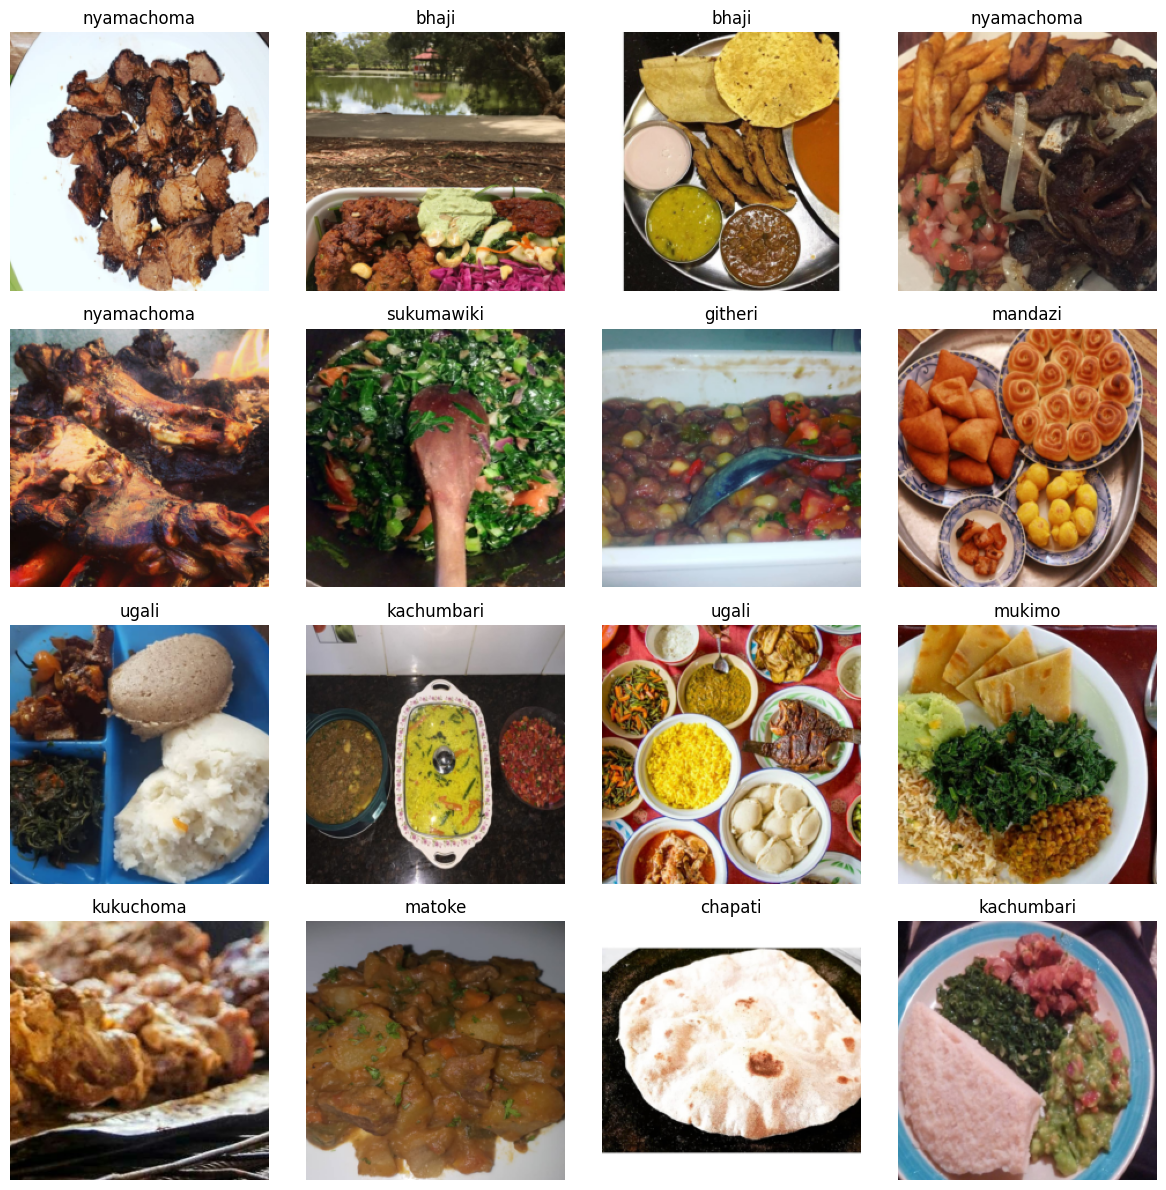

In [33]:
# Plot a few images
plt.rcParams["figure.figsize"] = (15, 9)
plt.figure
for images, labels, _ in sample_images():
    num_images = len(labels)
    
    # Calculate the number of rows and columns
    cols = int(np.ceil(np.sqrt(num_images)))
    rows = int(np.ceil(num_images / cols))
    plt.rcParams["figure.figsize"] = (cols * 3, rows * 3)
    fig, axes = plt.subplots(rows, cols)
    axes = axes.flatten()
    class_names = classesNumToNames() # Transform the class indices to the respective names
    for i in range(num_images):
        img = F.to_pil_image(images[i])
        axes[i].imshow(img)
        cl_idx = labels[i].item()
        axes[i].set_title('{0}'.format(class_names[cl_idx]))
        axes[i].axis('off')

    # Hide any remaining axes if number of images is less than grid size
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    break

In [34]:
# Create the TensorBoard visualizer
tb_visualizer = Visualizer(log_dir="tb_logs/01")

tensorboard --logdir=tb_logs/01 --load_fast=false --bind_all


In [35]:
trainer = Trainer(train_loader, valid_loader, train_config, visualizer=tb_visualizer)  # Initialize the Trainer
trainer.useModel(model_modified)
trainer.setConfig(train_config)

In [36]:
# Setup the train components
criterion = nn.CrossEntropyLoss()
optimizer = ### CODE REMOVED
lr_scheduler = ### CODE REMOVED

In [37]:
train_loss, test_loss, train_acc, test_acc = trainer.fit(criterion, optimizer, lr_scheduler)

<< EPOCH 1 >>


2024-07-30 03:22:56.549025: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 03:22:56.577191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 03:22:56.991438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-30 03:22:57.518404: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

2.16.1


2024-07-30 03:22:58.140973: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 03:22:58.167718: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 03:22:58.561993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-30 03:22:59.119367: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

[Training] Used images: 1600/5236, Loss: 1.3850, Acc: 0.6250
[Training] Used images: 3200/5236, Loss: 1.2284, Acc: 0.6250
[Training] Used images: 4800/5236, Loss: 0.4913, Acc: 0.8125
[Training] Elapsed 146.50s, 146.50 s/epoch, 0.45 s/batch, ets 7178.42s, Loss: 1.3958, Acc: (60%)
[Validation] Correct pred: 974/1300, Loss: 0.776, Acc: (75%)
Model improved, saving...

<< EPOCH 2 >>
[Training] Used images: 1600/5236, Loss: 0.7288, Acc: 0.8125
[Training] Used images: 3200/5236, Loss: 0.9429, Acc: 0.6875
[Training] Used images: 4800/5236, Loss: 0.7247, Acc: 0.8125
[Training] Elapsed 305.47s, 152.73 s/epoch, 0.47 s/batch, ets 7331.27s, Loss: 0.6287, Acc: (80%)
[Validation] Correct pred: 1005/1300, Loss: 0.684, Acc: (77%)
Model improved, saving...

<< EPOCH 3 >>
[Training] Used images: 1600/5236, Loss: 0.1944, Acc: 1.0000
[Training] Used images: 3200/5236, Loss: 0.4300, Acc: 0.8125
[Training] Used images: 4800/5236, Loss: 0.4570, Acc: 0.8125
[Training] Elapsed 464.71s, 154.90 s/epoch, 0.47 s/b

In [38]:
trainer.setConfig(train_config)
model_path = os.path.join(os.getcwd(), 'models', trainer.model.__class__.__name__.lower() + '_checkpt.pt')
trainer.loadModel(trainer.model, model_path)


[Predicting] Use the entire test set to predict images and evaluate the performance.


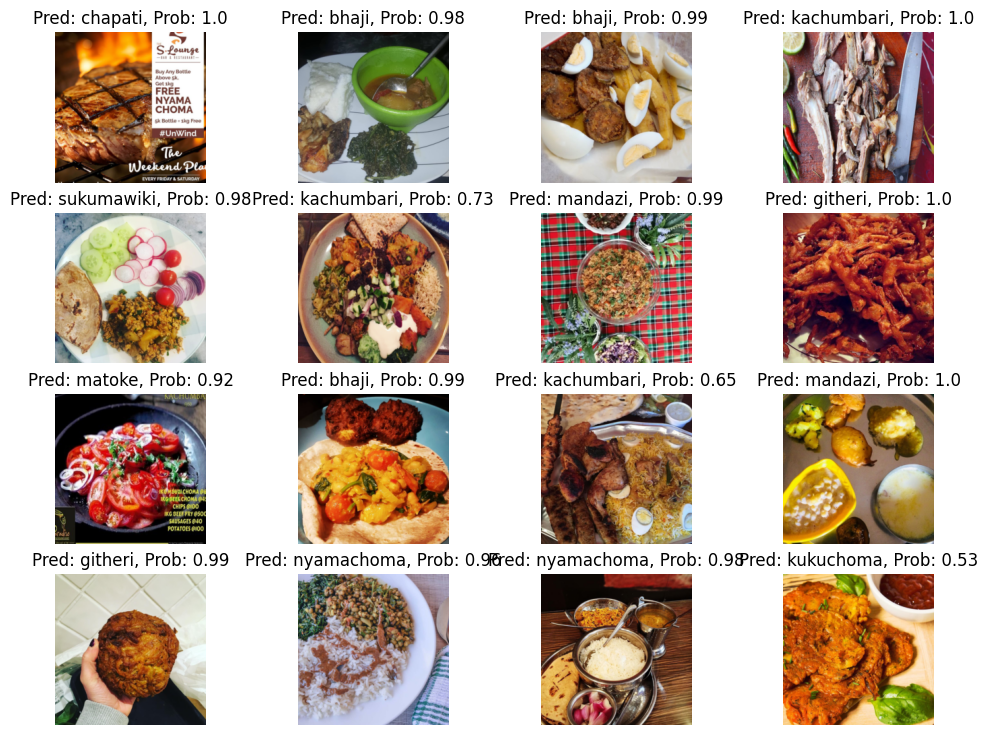

In [39]:
# For the model evaluation the validation set instead of the test set gets used, because the test set does not provide 
# labels to use for further evaluation.
# Note: The validation set gets loaded again without batch normalization
valid_dataset_eval =  ### CODE REMOVED
valid_loader_eval = torch.utils.data.DataLoader(valid_dataset_eval,
                                               batch_size=train_config.batch_size,
                                               shuffle=True,
                                               num_workers=train_config.num_workers)

targs, preds, probs, img_paths = predict(model_modified, train_config.device, valid_loader_eval)

# Predict images from the test set and plot one mini-batch of the predicted images and their respective probability
print('\n[Predicting] Use the entire test set to predict images and evaluate the performance.')
plot_predictions(preds[:train_config.batch_size], probs[:train_config.batch_size], valid_loader_eval, size=(12, 9))

In [40]:
# MODEL EVALUATION
metrics = EvaluationMetrics()

target_labels = [int(t) for t in targs]
predicted_labels = [int(p) for p in preds]

In [41]:
#print(target_labels.keys())
print("Calculating the accuracy based on the validation-set")
metrics.accuracy(targets=target_labels, predictions=predicted_labels)

Calculating the accuracy based on the validation-set
The accuracy is 81.23076923076923%


In [42]:
print("Calculating the f1-score based on the validation-set")
metrics.f1Score(targets=target_labels, predictions=predicted_labels)

Calculating the f1-score based on the validation-set
The f1 score is 78.6190603287419%


Calculating the confusion matrix based on the validation-set


/tmp/ipykernel_131596/4003745102.py:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


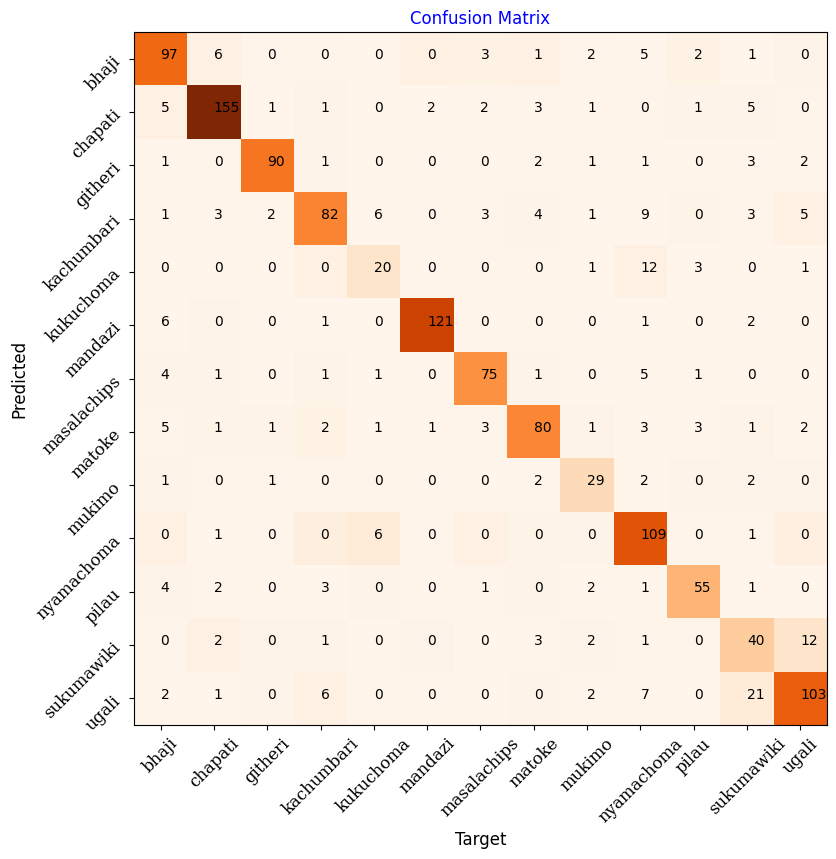

In [43]:
print("Calculating the confusion matrix based on the validation-set")
class_indices = [idx for idx in range(0, valid_loader_eval.dataset.num_classes)]
class_names = classesNumToNames()

metrics.confusionMatrix(
    target_labels = target_labels,
    predicted_labels = predicted_labels,
    class_names = list(class_names.values()))

In [57]:
# Predict the images based on the test-set
targs, preds, probs, img_paths = predict(model_modified, train_config.device, test_loader)

In [61]:
# Predicted accuracy on the test-set
acc_test = probs.sum() / len(probs)
print("Accuracy on the test set is {:.4}%".format(acc_test * 100.))

Accuracy on the test set is 89.82%


## <font style="color:green">Section 8: TensorBoard Screenshots</font>

In [19]:
from IPython.display import Image

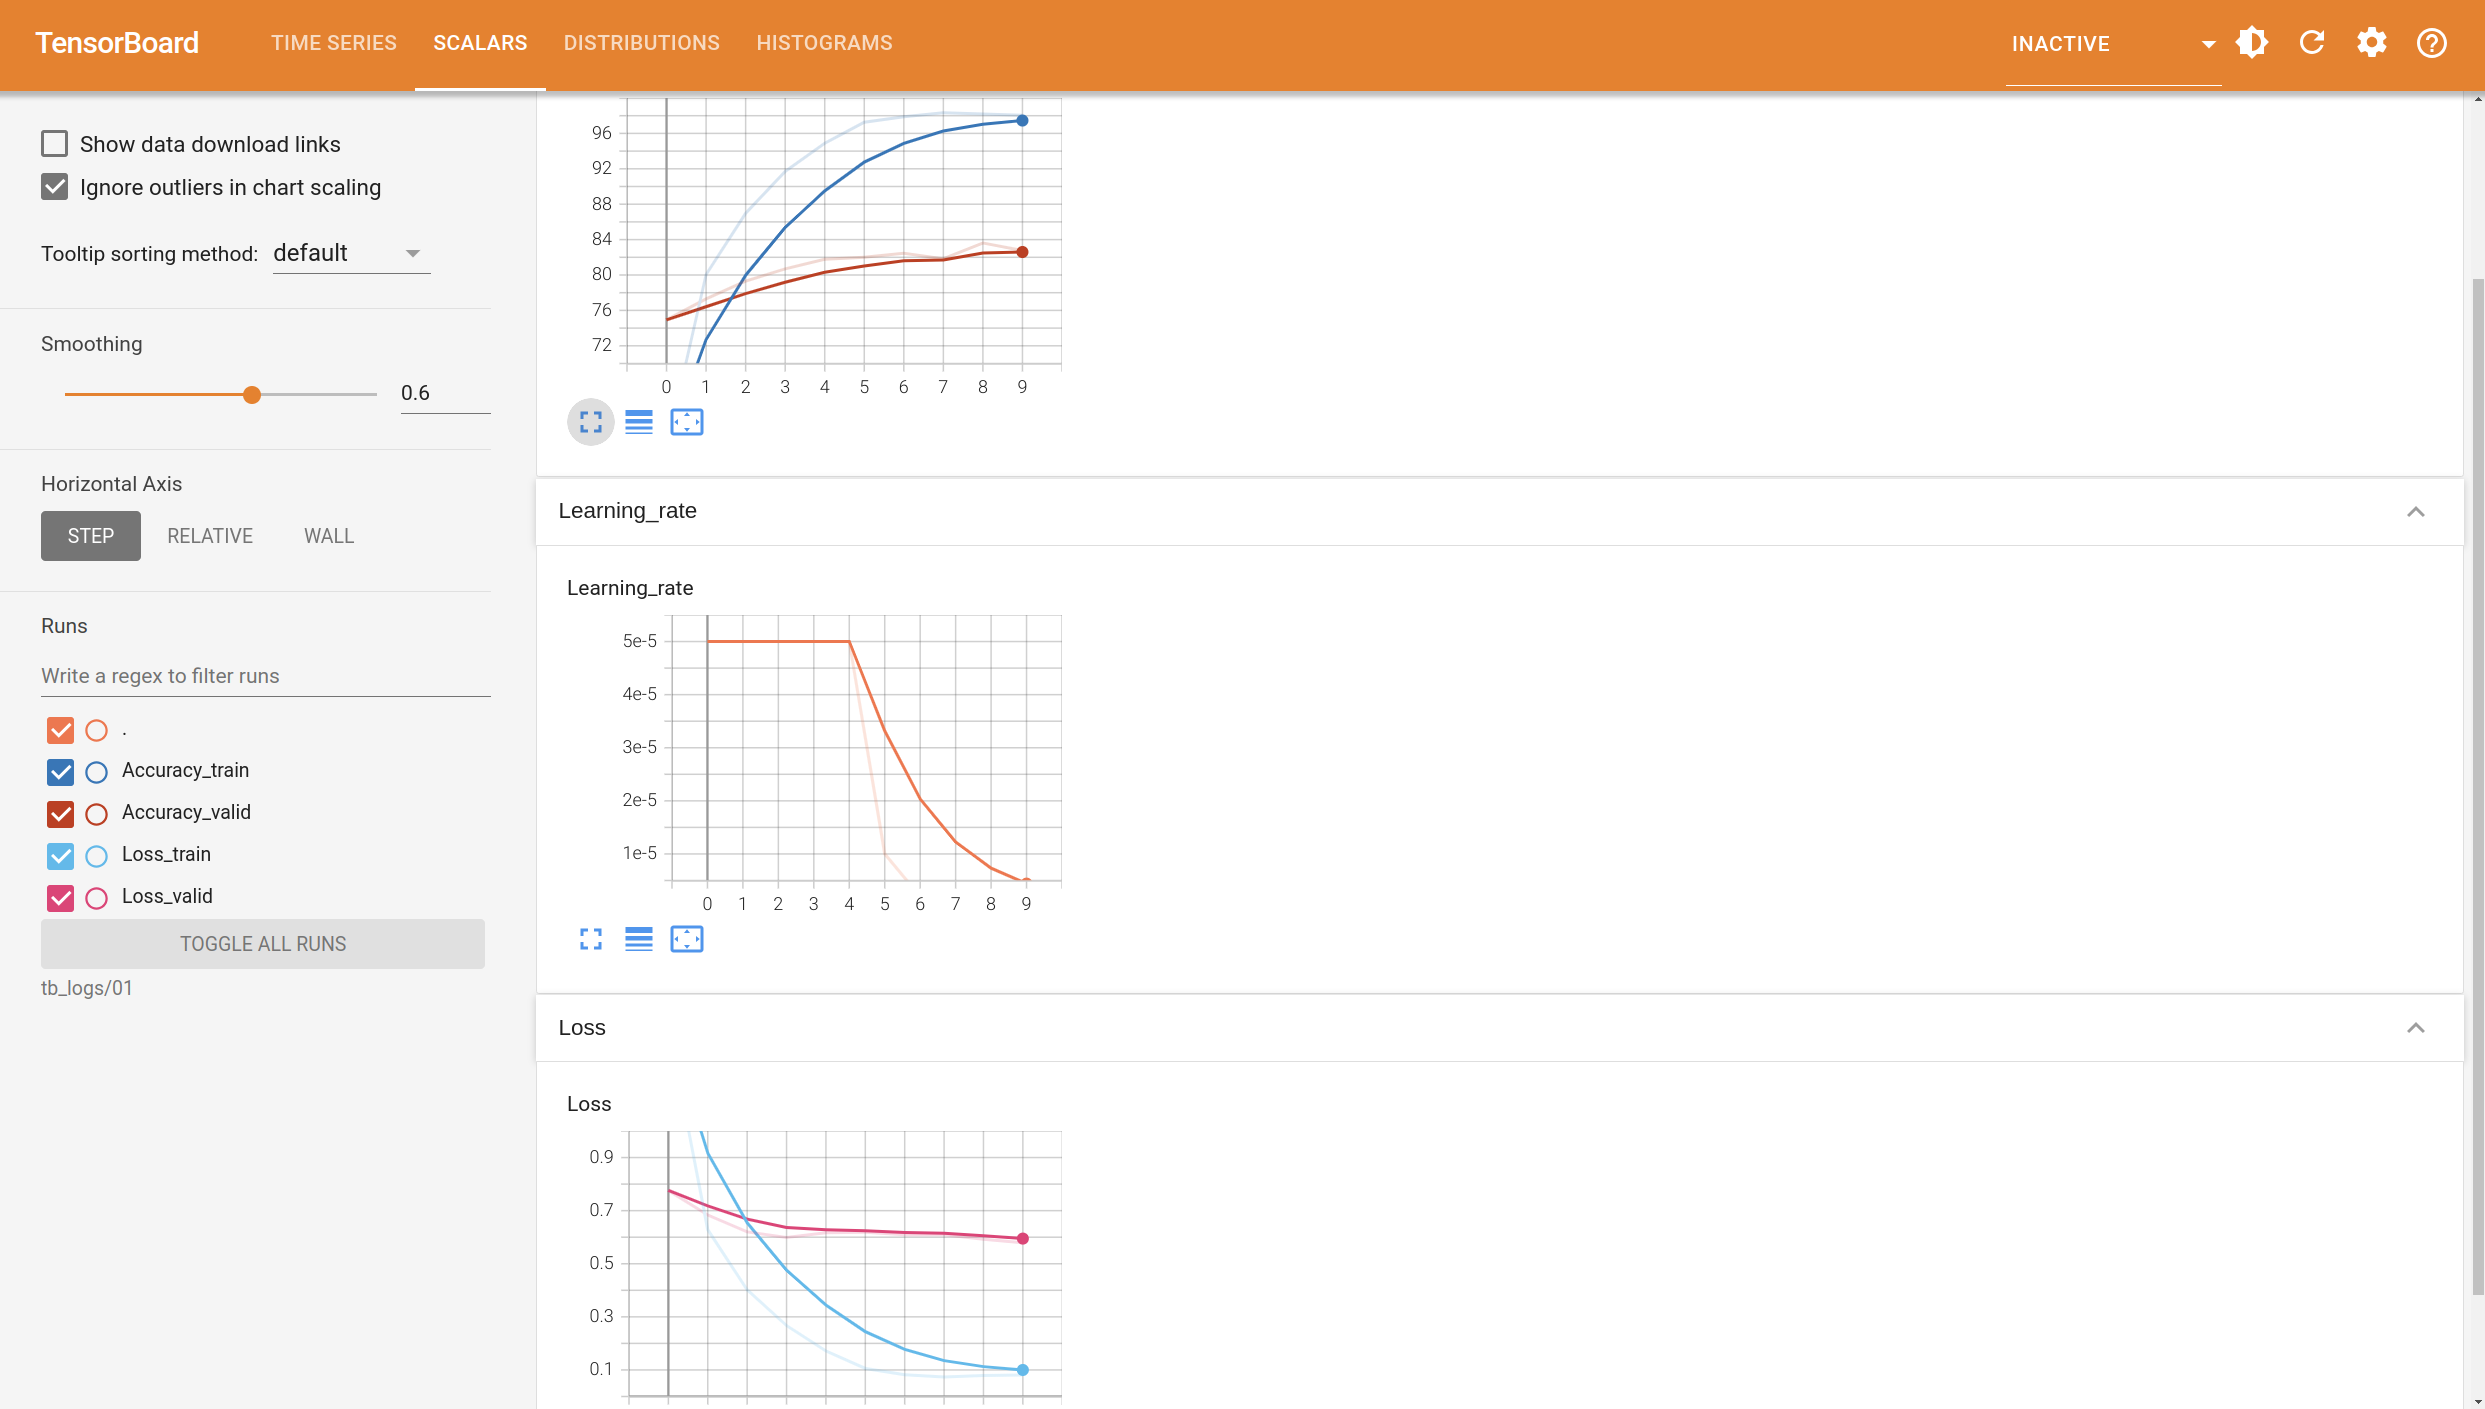

In [20]:
Image(filename="./img/loss_acc_lr.png")

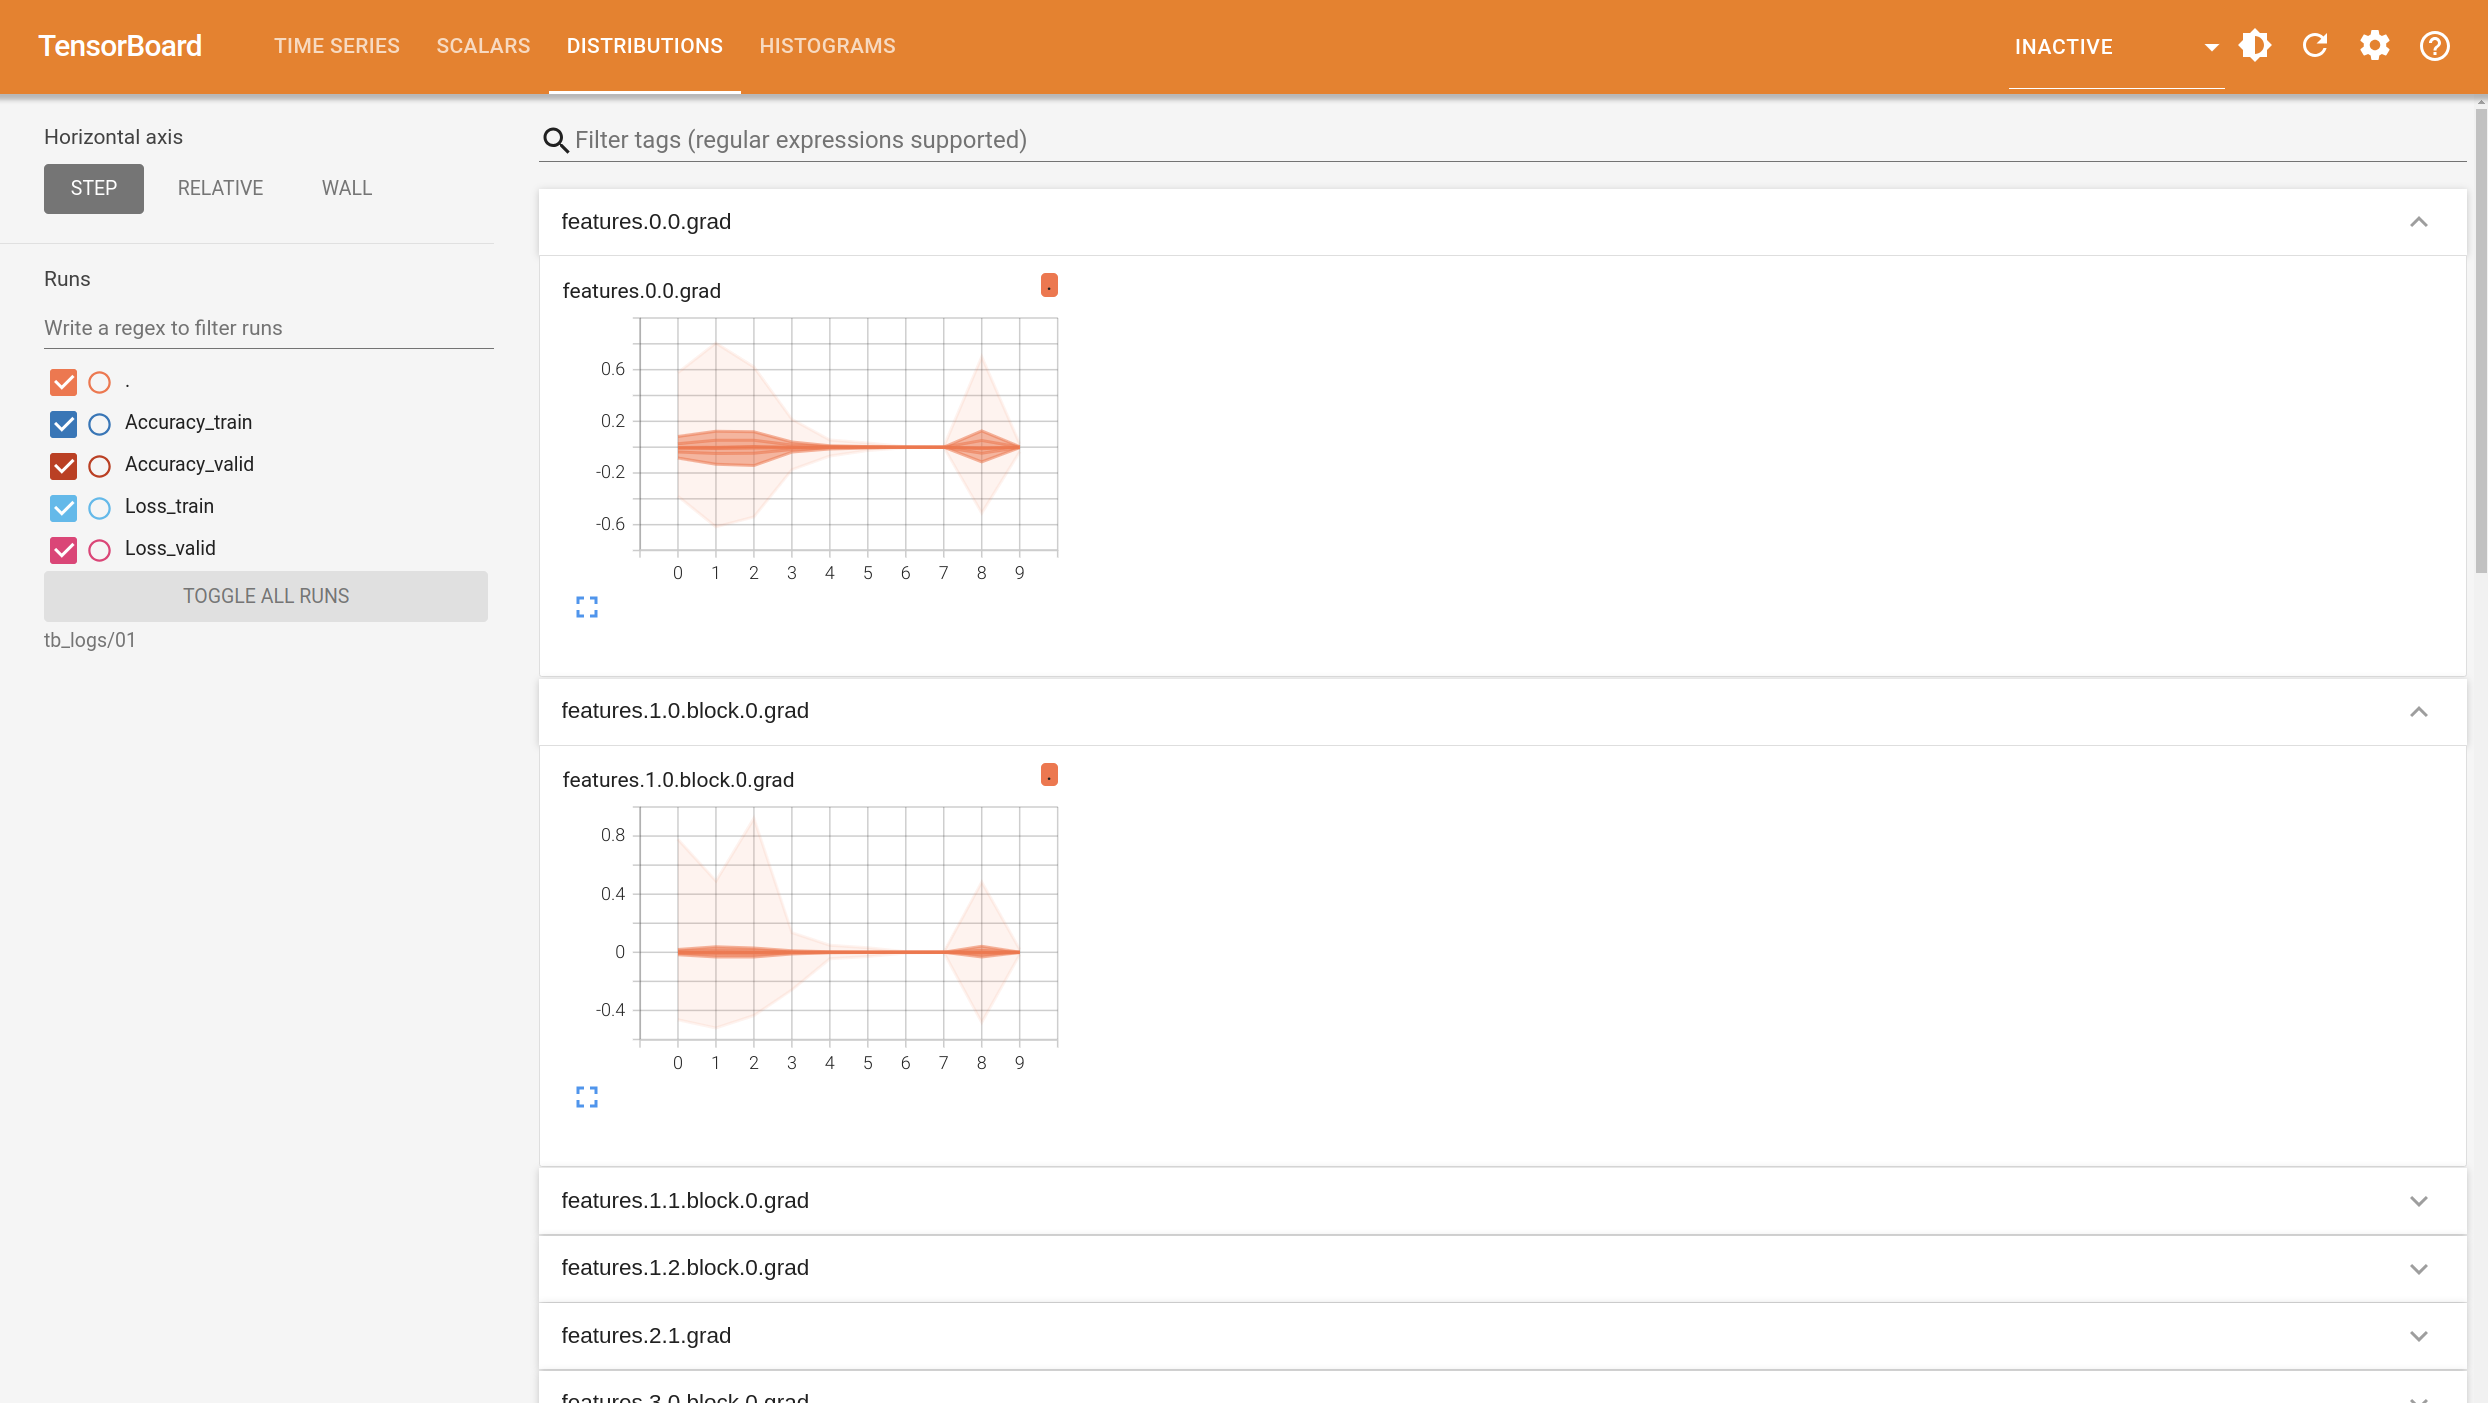

In [21]:
Image(filename="./img/distributions.png")

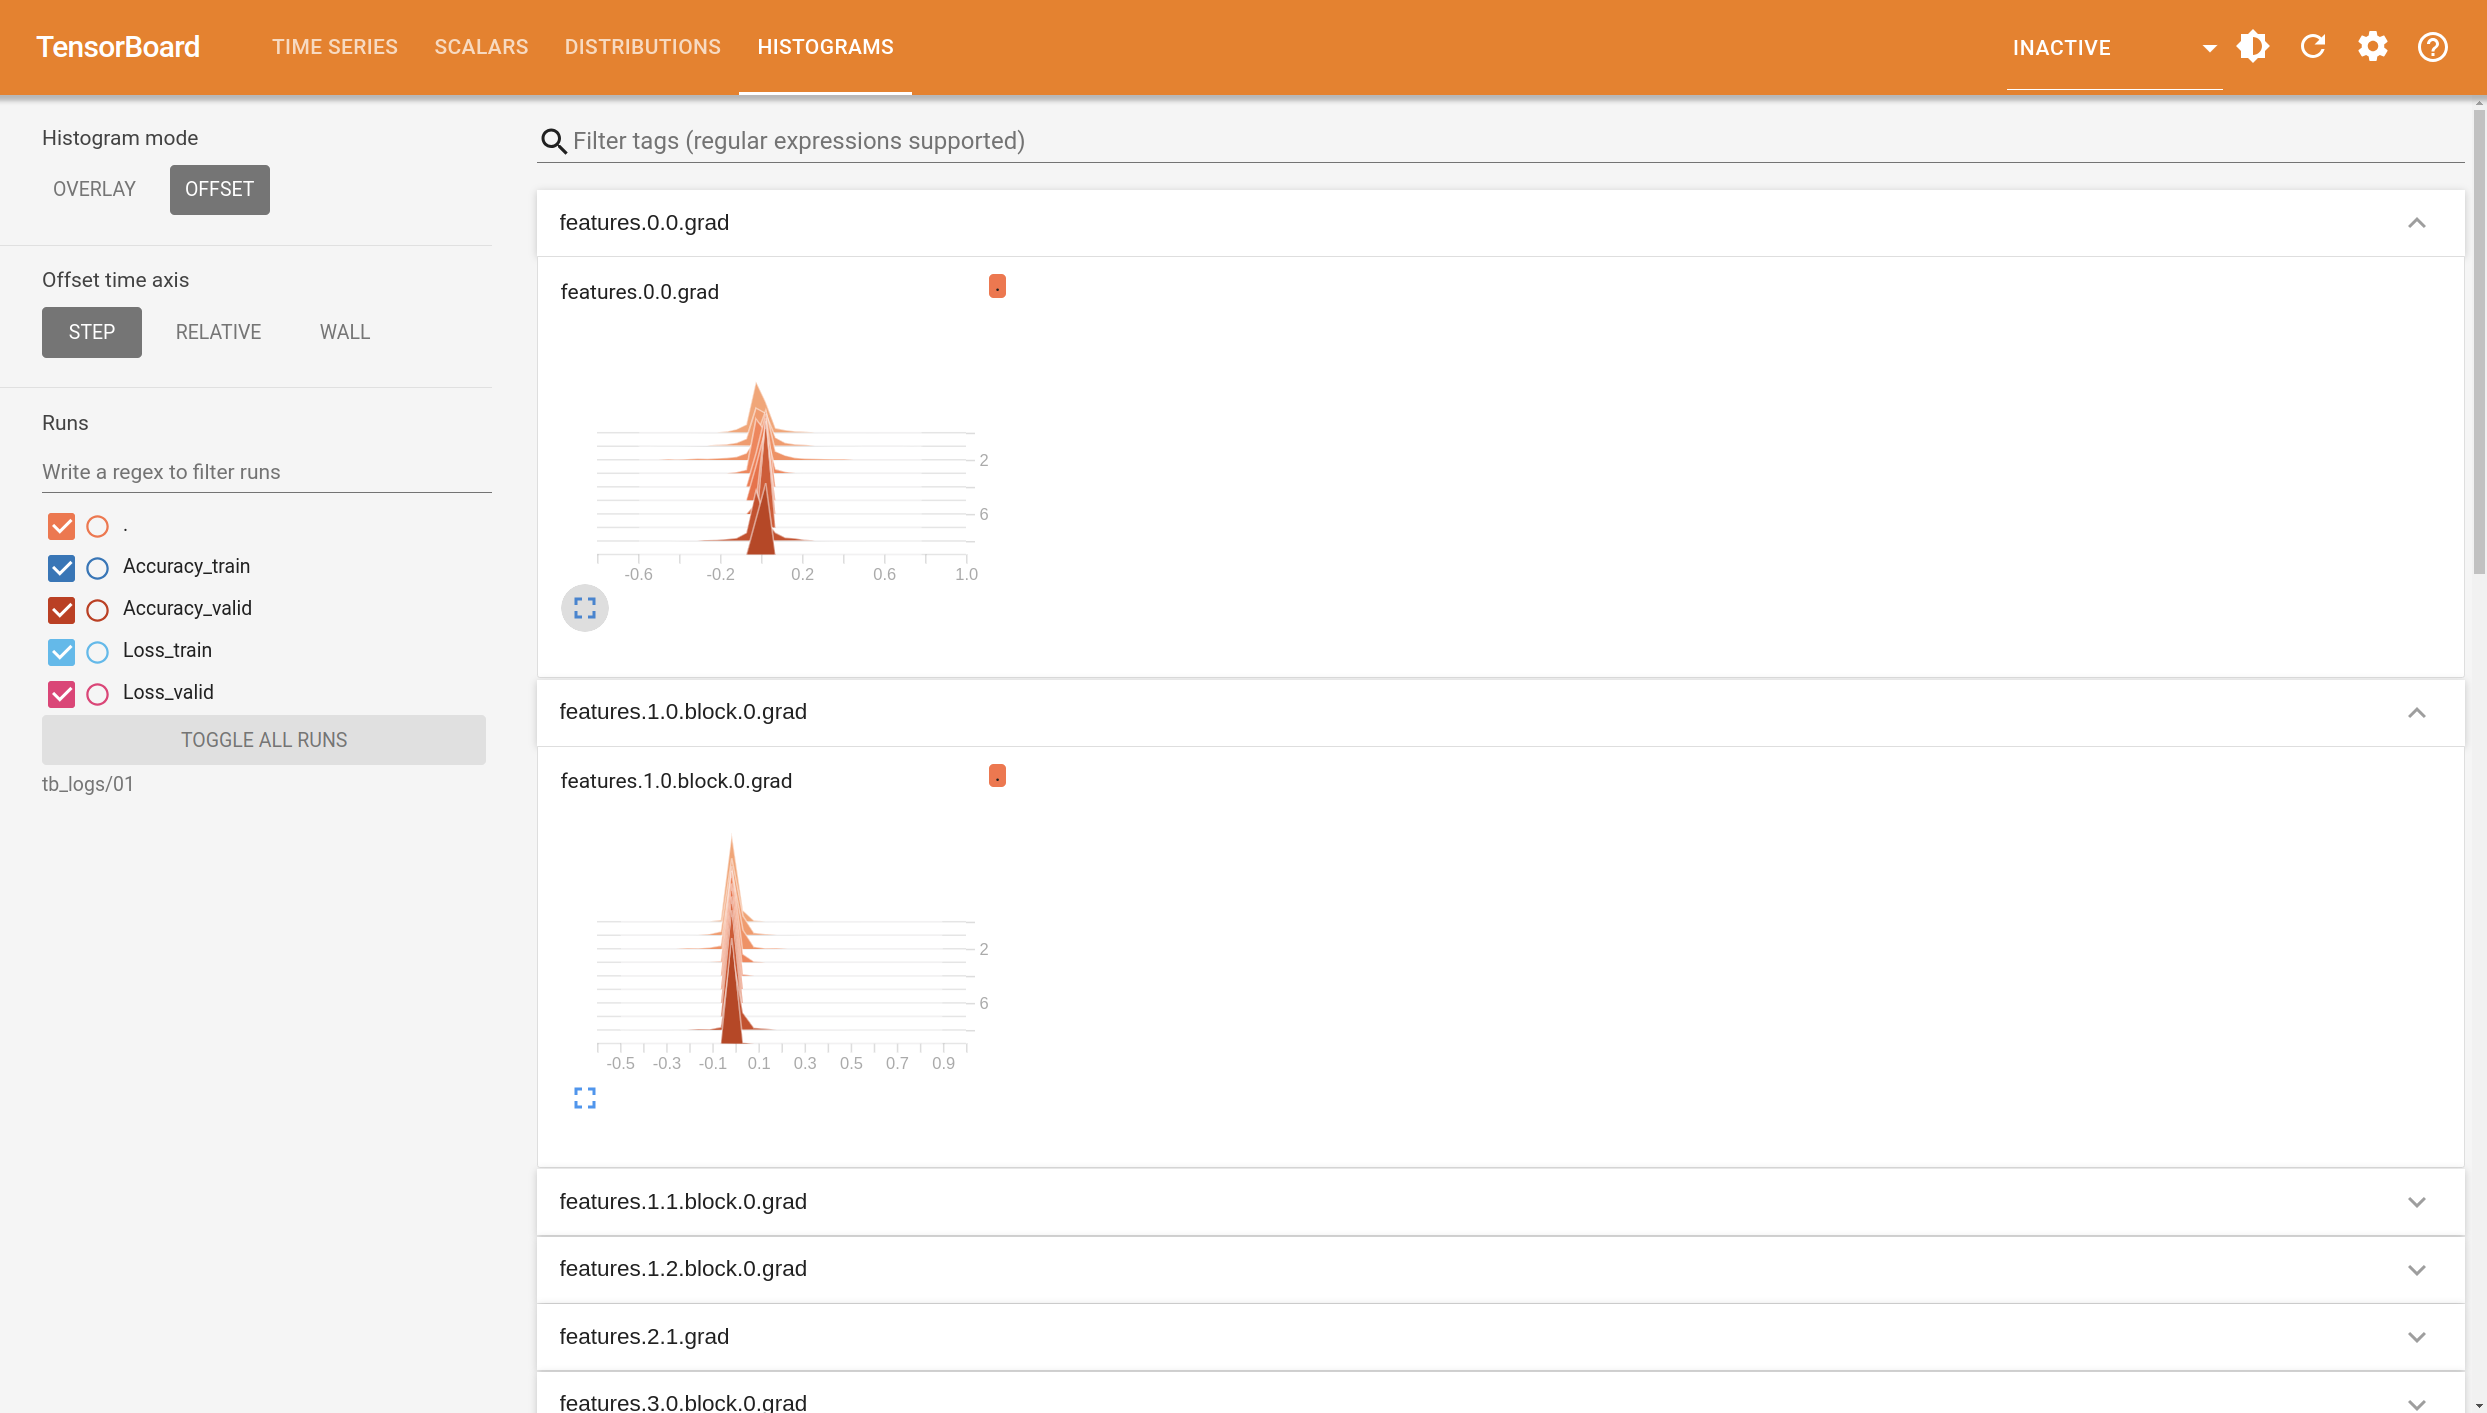

In [22]:
Image(filename="./img/hist.png")